# Diabetes Prediction with Classification Models
In this project, I will explore some popular ML models on the classification problem of diabetes.\
\
All models will use the same test and train data sets.\
\
Model Accuracy, precision, recall and ROC/AUC will be noted for comparison\
\
The models covered are:
- 1: Logistic Regression
- 2: SVM (GridSearchCV on hyperparameters)
- 3: Random Forest


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Read CSV and check NA values
- It does not seem to be any NA values in this dataset


In [ ]:
def check_na(n:str):
    global diabetes
    diabetes = pd.read_csv(n)
    return diabetes.isna().sum()

check_na('diabetes.csv')

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Value of 0
-  However, values of 0 can indicate missing values in a lot of columns.
-  There are a lot of 0 values in many columns. They can indicate missing values

In [ ]:
for i in range(len(diabetes.columns) - 1):
    print('The number of 0 value is ' + str(sum(diabetes.iloc[:,i] == 0)) + ' in ' + diabetes.columns[i])

The number of 0 value is 111 in Pregnancies
The number of 0 value is 5 in Glucose
The number of 0 value is 35 in BloodPressure
The number of 0 value is 227 in SkinThickness
The number of 0 value is 374 in Insulin
The number of 0 value is 11 in BMI
The number of 0 value is 0 in DiabetesPedigreeFunction
The number of 0 value is 0 in Age


### Intepretaion
- DiabetesPedigreeFunction and Age are all good
- It is possible for Pregnancies to be 0.

- We need to find ways tp fill:\
Glucose, BloodPressure, SkinThickness, Insulin and BMI


### Median Imputation
### Fill Glucose, BloodPressure and BMI
- They have 5, 35, and 11 missing values respectively
- Compared to 768 rows, the missing values are relatively few.
- We can fill the missing value with median.

In [ ]:
def Glucose_fill():
    diabetes['Glucose'] = diabetes['Glucose'].replace(0, diabetes[diabetes['Glucose'] != 0]['Glucose'].median())
    return sum(diabetes['Glucose'] == 0)

def BP_fill():
    diabetes['BloodPressure'] = diabetes['BloodPressure'].replace(0, diabetes[diabetes['BloodPressure'] != 0]['BloodPressure'].median())
    return sum(diabetes['BloodPressure'] == 0)

def BMI_fill():
    diabetes['BMI'] = diabetes['BMI'].replace(0, diabetes[diabetes['BMI'] != 0]['BMI'].median())
    return sum(diabetes['BMI'] == 0)

Glucose_fill()
BP_fill()
BMI_fill()

0

### KNN Imputation
### Fill SkinThickness and Insulin
- There are 227 and 374 missing values respectively
- Median or mean imputation will not work well
- Thus, I decided to do KNN imputation of k = 5
- Use the first 8 columns (independent variables)

In [ ]:
def KNN_impute():
    # Replace 0 with NaN in these two columns
    diabetes['SkinThickness'] = diabetes['SkinThickness'].replace(0, float('NaN'))
    diabetes['Insulin'] = diabetes['Insulin'].replace(0, float('NaN'))
    
    # Define Imputer, K = 5 
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    imputer.fit(diabetes.iloc[:, :-1])
    diabetes_trans = imputer.transform(diabetes.iloc[:, :-1])
    
    global df
    df = pd.DataFrame(diabetes_trans, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    df['Outcome'] = diabetes['Outcome']
    
    return df.isna().sum()

KNN_impute()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Now, we have successfully filled all missing values in our data. We can move forward to the classification algorithm

## Before Classification -- Train Test Split
We will use cross validation through out different algorithms\
In order to make model results comparable, we will use the same train test sets.\
We will use 80% as train and 20% as test.

In [ ]:
# Creating train and test data
X = df.iloc[:, :-1]
y = df['Outcome']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## Logistic Regression

In [ ]:
# Train and predict
my_logit = LogisticRegression()
my_logit.fit(X_train, y_train)
y_pred = my_logit.predict(X_test)

# Accuracy, Precision and Recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8051948051948052
Precision: 0.7073170731707317
Recall: 0.6170212765957447


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


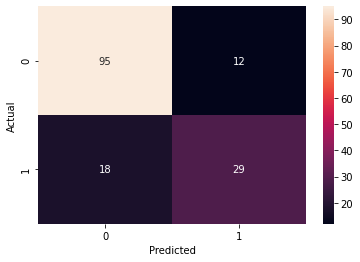

In [ ]:
#Confusion Matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

### In predicting the test data:
- There are 95 True Negatives
- There are 29 True Positives
- There are 18 False Negatives
- There are 12 False Positives

Accuracy = 0.805
Precision = 0.707
Recall = 0.617

## Intepretation on Business Impact
- 70% of the patients predicted to have diabetes actually have diabetes.
- This will result roughly 30% of people wrongly diagnosed with diabetes.

- There are 18 False Negatives resulting in a bad Recall.
- This means that roughly 61.7% of all patients who indeed have diabetes will be diagnosed correctly by this model.
- I will only suggest this model as a rough reference for business use. Doctors will still need to rely on their judgement.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.882


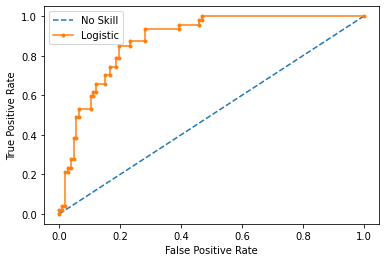

In [ ]:
# ROC AUC Curve
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = my_logit.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### ROC AUC:
Logistic regression has a score of 0.882

## Support Vector Machine
- First, we just run SVC with everything set to default

In [ ]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7857142857142857
Precision: 0.7058823529411765
Recall: 0.5106382978723404


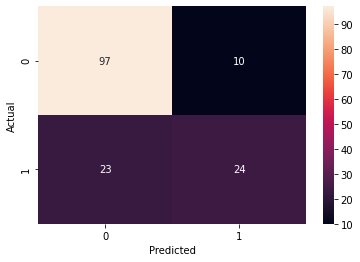

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

Default SVC gives us:\
\
Accuracy: 0.785\
Precision: 0.705\
Recall: 0.510

## GridSearchCV 
\
Let's use GridsearchCV to find the best hyperparameters.

### this one took 46 mins to run
I honestly want to explore RBF and Polynomial Kernels too, but it is too time-consuming for my laptop.\
\
I believe this is mainly because of the grids, as well as probability = True\
It takes SVC additional time to calculate probability


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear']} 

grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3,n_jobs=-1) 

# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 46.6min finished


{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


### Best Hyperparameters for SVC
- C = 100
- Gamma = Scale
- Kernel = Linear

How does it perform under these hyperparameters?

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, grid_predictions))
print("Precision:",metrics.precision_score(y_test, grid_predictions))
print("Recall:",metrics.recall_score(y_test, grid_predictions))

Accuracy: 0.8181818181818182
Precision: 0.7111111111111111
Recall: 0.6808510638297872


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.865


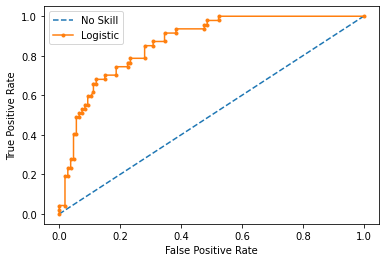

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = grid.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

The SVM method gives us an ROC AUC of 0.863. Slightly worse than logistic regression


## Business Impact Intepretation:
- compared to the logistic regression model, SVM improved Recall significantly.
- We have roughly the same precision, which is 71%
- Recall became 68%, which means that 68% of the patients who actually have diabetes will be correctly identified.

- Our doctor can refer to this model with more confidence than logistic regression. Although they should not trust this model fully.

# Random Forest Model
- I decided to plant 10000 trees in this model.
- The model have more potential if we plant more than 10000 trees, but that will be very time-consuming.

In [ ]:
random.seed(10)
clf=RandomForestClassifier(n_estimators=10000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8246753246753247
Precision: 0.717391304347826
Recall: 0.7021276595744681


### Random Forest Performance
- Accuracy: 0.824
- Precision 0.717
- Recall: 0.702\
\
Overall, a pretty significant improvement over Logistic Regression and SVM

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.873


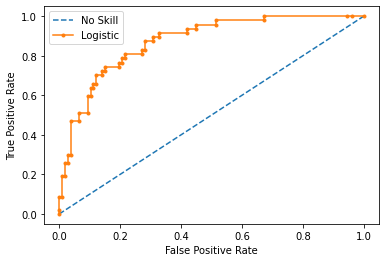

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### ROC AUC = 0.873 for Random Forest

## A quick look on feature importance

No handles with labels found to put in legend.


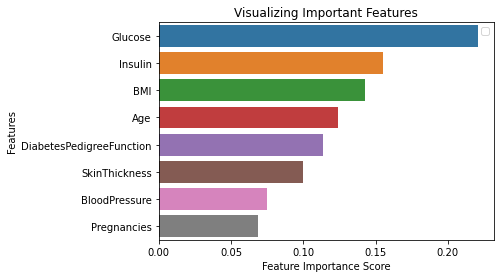

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sn.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



## Business Intepretation:
- RF model has 71.7% Precision and 70.2% Recall
- This is the best performing model so far.
- Doctors can refer to the prediction when diagnosing a patient.
- We can also use this model to proactively search for patients with high potential to develop diabetes in the future.
- We can target the patients identified with diabetes, do some preventative care
- Also, looks like Glucose is the most important feature for diabetes prediction.